In [1]:
import matplotlib

import time
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

from keras.models import Sequential
from keras.layers import Conv2D, Conv2DTranspose, Reshape
from keras.layers import Flatten, BatchNormalization, Dense, Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

from IPython.display import SVG
#from keras.utils import model_to_dot
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


In [2]:


# Creates the discriminator model. This model tries to classify images as real
# or fake.
def construct_discriminator(image_shape):

    discriminator = Sequential()
    discriminator.add(Conv2D(filters=64, kernel_size=(5, 5),
                             strides=(2, 2), padding='same',
                             data_format='channels_last',
                             kernel_initializer='glorot_uniform',
                             input_shape=(image_shape)))
    discriminator.add(LeakyReLU(0.2))

    discriminator.add(Conv2D(filters=128, kernel_size=(5, 5),
                             strides=(2, 2), padding='same',
                             data_format='channels_last',
                             kernel_initializer='glorot_uniform'))
    discriminator.add(BatchNormalization(momentum=0.5))
    discriminator.add(LeakyReLU(0.2))

    discriminator.add(Conv2D(filters=136, kernel_size=(5, 5),
                             strides=(2, 2), padding='same',
                             data_format='channels_last',
                             kernel_initializer='glorot_uniform'))
    discriminator.add(BatchNormalization(momentum=0.5))
    discriminator.add(LeakyReLU(0.2))

    discriminator.add(Conv2D(filters=512, kernel_size=(5, 5),
                             strides=(2, 2), padding='same',
                             data_format='channels_last',
                             kernel_initializer='glorot_uniform'))
    discriminator.add(BatchNormalization(momentum=0.5))
    discriminator.add(LeakyReLU(0.2))

    discriminator.add(Flatten())
    discriminator.add(Dense(1))
    discriminator.add(Activation('sigmoid'))

    optimizer = Adam(lr=0.0002, beta_1=0.5)
    discriminator.compile(loss='binary_crossentropy',
                          optimizer=optimizer,
                          metrics=None)

    print('discriminator')
    discriminator.summary()

    return discriminator

# Creates the generator model. This model has an input of random noise and
# generates an image that will try mislead the discriminator.
def construct_generator():

    generator = Sequential()

    generator.add(Dense(units=17 * 17* 512,#128 * (136//2) * (136//2),#units=16 * 16 * 512,
                            kernel_initializer='glorot_uniform',
                            input_shape=(1, 1, 100)))
    generator.add(Reshape(target_shape=(17, 17,512)))
    generator.add(BatchNormalization(momentum=0.5))
    generator.add(Activation('relu'))

    generator.add(Conv2DTranspose(filters=256, kernel_size=(5, 5),
                                      strides=(2, 2), padding='same',
                                      data_format='channels_last',
                                      kernel_initializer='glorot_uniform'))
    generator.add(BatchNormalization(momentum=0.5))
    generator.add(Activation('relu'))

    generator.add(Conv2DTranspose(filters=128, kernel_size=(5, 5),
                                      strides=(2, 2), padding='same',
                                      data_format='channels_last',
                                      kernel_initializer='glorot_uniform'))
    generator.add(BatchNormalization(momentum=0.5))
    generator.add(Activation('relu'))




    generator.add(Conv2DTranspose(filters=3, kernel_size=(5, 5),
                                      strides=(2, 2), padding='same',
                                      data_format='channels_last',
                                      kernel_initializer='glorot_uniform'))
    generator.add(Activation('tanh'))

    optimizer = Adam(lr=0.00015, beta_1=0.5)
    generator.compile(loss='binary_crossentropy',
                          optimizer=optimizer,
                          metrics=None)

    print('generator')
    generator.summary()

    return generator


# Displays a figure of the generated images and saves them in as .png image
def save_generated_images(generated_images, epoch, batch_number):

    plt.figure(figsize=(8, 8), num=2)
    gs1 = gridspec.GridSpec(8, 8)
    gs1.update(wspace=0, hspace=0)

    for i in range(64):
        ax1 = plt.subplot(gs1[i])
        ax1.set_aspect('equal')
        image = generated_images[i, :, :, :]
        image += 1
        image *= 127.5
        fig = plt.imshow(image.astype(np.uint8))
        plt.axis('off')
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

    plt.tight_layout()
    save_name = './output/generatedSamples_epoch' + str(
        epoch + 1) + '_batch' + str(batch_number + 1) + '.png'

    plt.savefig(save_name, bbox_inches='tight', pad_inches=0)
    plt.pause(0.0000000001)
    plt.show()


# Main train function
def train_dcgan(batch_size, epochs, image_shape, dataset_path):
    # Build the adversarial model that consists in the generator output
    # connected to the discriminator
    generator = construct_generator()
    discriminator = construct_discriminator(image_shape)

    gan = Sequential()
    # Only false for the adversarial model
    discriminator.trainable = False
    gan.add(generator)
    gan.add(discriminator)

    if os.path.exists("./output/generator_weights.h5"):
        print('loaded generator model weights')
        generator.load_weights('./output/generator_weights.h5')

    if os.path.exists("./output/discriminator_weights.h5"):
        print('loaded discriminator model weights')
        discriminator.load_weights('./output/discriminator_weights.h5')

    optimizer = Adam(lr=0.001, beta_1=0.5)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer,
                metrics=None)

    # Create a dataset Generator with help of keras
    dataset_generator = load_dataset(dataset_path, batch_size, image_shape)

    # 2719 is the total number of images on the dataset
    number_of_batches = int( 12856/ batch_size)

    # Variables that will be used to plot the losses from the discriminator and
    # the adversarial models
    adversarial_loss = np.empty(shape=1)
    discriminator_loss = np.empty(shape=1)
    batches = np.empty(shape=1)

    # Allo plot updates inside for loop
    plt.ion()

    current_batch = 0

    # Let's train the DCGAN for n epochs
    for epoch in range(epochs):

        print("Epoch " + str(epoch+1) + "/" + str(epochs) + " :")

        for batch_number in range(number_of_batches):

            start_time = time.time()

            # Get the current batch and normalize the images between -1 and 1
            real_images = dataset_generator.next()
            real_images /= 127.5
            real_images -= 1

            # The last batch is smaller than the other ones, so we need to
            # take that into account
            current_batch_size = real_images.shape[0]

            # Generate noise
            noise = np.random.normal(0, 1,
                                     size=(current_batch_size,) + (1, 1, 100))

            # Generate images
            generated_images = generator.predict(noise)

            # Add some noise to the labels that will be
            # fed to the discriminator
            real_y = (np.ones(current_batch_size) -
                      np.random.random_sample(current_batch_size) * 0.2)
            fake_y = np.random.random_sample(current_batch_size) * 0.2

            # Let's train the discriminator
            discriminator.trainable = True

            d_loss = discriminator.train_on_batch(real_images, real_y)
            d_loss += discriminator.train_on_batch(generated_images, fake_y)

            discriminator_loss = np.append(discriminator_loss, d_loss)

            # Now it's time to train the generator
            discriminator.trainable = False

            noise = np.random.normal(0, 1,
                                     size=(current_batch_size * 2,) +
                                     (1, 1, 100))

            # We try to mislead the discriminator by giving the opposite labels
            fake_y = (np.ones(current_batch_size * 2) -
                      np.random.random_sample(current_batch_size * 2) * 0.2)

            g_loss = gan.train_on_batch(noise, fake_y)
            adversarial_loss = np.append(adversarial_loss, g_loss)
            batches = np.append(batches, current_batch)

            # Each 50 batches show and save images
            '''if((batch_number + 1) % 5 == 0 and
               current_batch_size == batch_size):
                save_generated_images(generated_images, epoch, batch_number)'''

            time_elapsed = time.time() - start_time

            # Display and plot the results
            print("     Batch " + str(batch_number + 1) + "/" +
                  str(number_of_batches) +
                  " generator loss | discriminator loss : " +
                  str(g_loss) + " | " + str(d_loss) + ' - batch took ' +
                  str(time_elapsed) + ' s.')

            current_batch += 1

        # Save the model weights each 5 epochs
        '''if (epoch + 1) % 100 == 0:
            discriminator.trainable = True
            save_generated_images(generated_images, epoch, batch_number)
            generator.save_weights('/output/generator_weights%d.h5' % epoch)
            discriminator.save_weights('/output/discriminator_weights%d.h5' % epoch)'''

        # Each epoch update the loss graphs
        plt.figure(1)
        plt.plot(batches, adversarial_loss, color='green',
                 label='Generator Loss')
        plt.plot(batches, discriminator_loss, color='blue',
                 label='Discriminator Loss')
        plt.title("DCGAN Train")
        plt.xlabel("Batch Iteration")
        plt.ylabel("Loss")
        if epoch == 0:
            plt.legend()
        plt.pause(0.0000000001)
        plt.show()
        plt.savefig('./output/trainingLossPlot.png')

        discriminator.trainable = True
        save_generated_images(generated_images, epoch, batch_number)
        generator.save_weights('./output/generator_weights.h5')
        discriminator.save_weights('./output/discriminator_weights.h5')


In [3]:
def load_dataset(dataset_path, batch_size, image_shape):
    dataset_generator = ImageDataGenerator()
    dataset_generator = dataset_generator.flow_from_directory(
        dataset_path, target_size=(image_shape[0], image_shape[1]),
        batch_size=batch_size,
        class_mode=None)

    return dataset_generator

In [4]:
dataset_path ='ut-zap50k-images-square/Shoes/Sneakers and Athletic Shoes/'
dataset=load_dataset(dataset_path,32,(136,136,3))

Found 12859 images belonging to 336 classes.


In [5]:
real_images = dataset.next()
real_images /= 127.5
real_images -= 1
real_images.shape

(32, 136, 136, 3)

In [6]:
generator = construct_generator()
discriminator = construct_discriminator((136,136,3))

Instructions for updating:
Colocations handled automatically by placer.
generator
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1, 1, 147968)      14944768  
_________________________________________________________________
reshape_1 (Reshape)          (None, 17, 17, 512)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 17, 17, 512)       2048      
_________________________________________________________________
activation_1 (Activation)    (None, 17, 17, 512)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 34, 34, 256)       3277056   
_________________________________________________________________
batch_normalization_2 (Batch (None, 34, 34, 256)       1024      
______________________________________

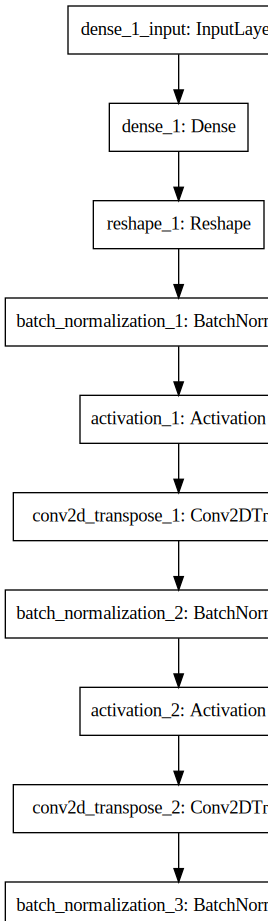

In [7]:
#import os
#os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

SVG(model_to_dot(generator).create(prog='dot', format='svg'))

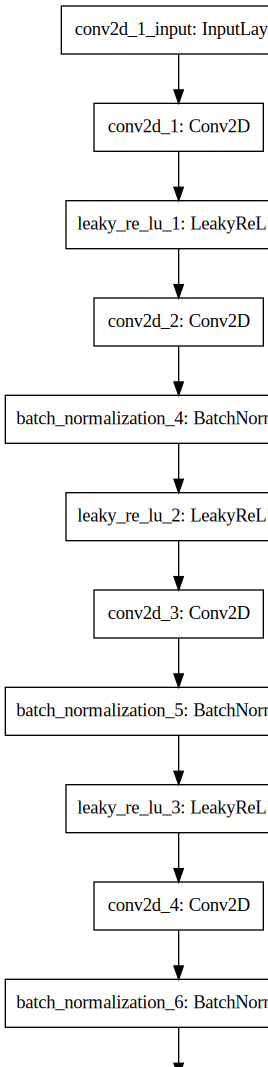

In [8]:
SVG(model_to_dot(discriminator).create(prog='dot', format='svg'))

In [10]:
def train_dcgan(batch_size, epochs, image_shape, dataset_path):
    generator = construct_generator()
    discriminator = construct_discriminator(image_shape)

    gan = Sequential()
    discriminator.trainable = False
    gan.add(generator)
    gan.add(discriminator)

    if os.path.exists("./output/generator_weights.h5"):
        print('loaded generator model weights')
        generator.load_weights('./output/generator_weights.h5')

    if os.path.exists("./output/discriminator_weights.h5"):
        print('loaded discriminator model weights')
        discriminator.load_weights('./output/discriminator_weights.h5')

    optimizer = Adam(lr=0.001, beta_1=0.5)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer,
                metrics=None)

    dataset_generator = load_dataset(dataset_path, batch_size, image_shape)

    number_of_batches = int( 12856/ batch_size)

    adversarial_loss = np.empty(shape=1)
    discriminator_loss = np.empty(shape=1)
    batches = np.empty(shape=1)

    plt.ion()
    current_batch = 0


    for epoch in range(epochs):
        print("Epoch " + str(epoch+1) + "/" + str(epochs) + " :")
        for batch_number in range(number_of_batches):
            start_time = time.time()

            real_images = dataset_generator.next()
            real_images /= 127.5
            real_images -= 1

            current_batch_size = real_images.shape[0]

            noise = np.random.normal(0, 1,size=(current_batch_size,) + (1, 1, 100))
            generated_images = generator.predict(noise)

            real_y = (np.ones(current_batch_size) -
                      np.random.random_sample(current_batch_size) * 0.2)
            fake_y = np.random.random_sample(current_batch_size) * 0.2

            discriminator.trainable = True

            d_loss = discriminator.train_on_batch(real_images, real_y)
            d_loss += discriminator.train_on_batch(generated_images, fake_y)
            discriminator_loss = np.append(discriminator_loss, d_loss)

            discriminator.trainable = False

            noise = np.random.normal(0, 1,
                                     size=(current_batch_size * 2,) +(1, 1, 100))

            fake_y = (np.ones(current_batch_size * 2) -
                      np.random.random_sample(current_batch_size * 2) * 0.2)

            g_loss = gan.train_on_batch(noise, fake_y)
            adversarial_loss = np.append(adversarial_loss, g_loss)
            batches = np.append(batches, current_batch)

            current_batch += 1

        


In [ ]:
def main():
    dataset_path ='data/ut-zap50k-images-square/Shoes/Sneakers and Athletic Shoes/
    batch_size = 64
    image_shape = (136,136, 3)
    epochs = 30
    train_dcgan(batch_size, epochs,
                image_shape, dataset_path)

In [11]:
def main():
    #dataset_path = './data/ut-zap50k-images-square/Shoes/Sneakers and Athletic Shoes/adidas/'
    dataset_path ='data/ut-zap50k-images-square/Shoes/Sneakers and Athletic Shoes/'#adidas/'
    batch_size = 64
    image_shape = (136,136, 3)
    epochs = 30
    train_dcgan(batch_size, epochs,
                image_shape, dataset_path)

if __name__ == "__main__":
    main()

generator
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 1, 1, 147968)      14944768  
_________________________________________________________________
reshape_2 (Reshape)          (None, 17, 17, 512)       0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 17, 17, 512)       2048      
_________________________________________________________________
activation_6 (Activation)    (None, 17, 17, 512)       0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 34, 34, 256)       3277056   
_________________________________________________________________
batch_normalization_8 (Batch (None, 34, 34, 256)       1024      
_________________________________________________________________
activation_7 (Activation)    (None, 34, 34, 

InternalError: Blas GEMM launch failed : a.shape=(32, 100), b.shape=(100, 147968), m=32, n=147968, k=100
	 [[{{node dense_3/MatMul}}]]
	 [[{{node activation_9/Tanh}}]]

## generating

In [3]:
generator = construct_generator()
generator.load_weights('./output/generator_weights.h5')

generator
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1, 1, 147968)      14944768  
_________________________________________________________________
reshape_1 (Reshape)          (None, 17, 17, 512)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 17, 17, 512)       2048      
_________________________________________________________________
activation_1 (Activation)    (None, 17, 17, 512)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 34, 34, 256)       3277056   
_________________________________________________________________
batch_normalization_2 (Batch (None, 34, 34, 256)       1024      
_________________________________________________________________
activation_2 (Activation)    (None, 34, 34, 256)       0         


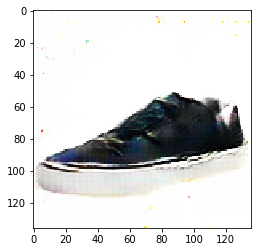

In [68]:
current_batch_size=1
noise = np.random.normal(0, 1,size=(current_batch_size,) + (1, 1, 100))
generated_images = generator.predict(noise)
generated_images += 1
generated_images *= 127.5

plt.imshow(generated_images[0].astype(np.uint8))
plt.show()